In [1]:
import sys
sys.path.append('../../')
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.datasets import MNIST
from torchvision import transforms
import time
from collections import OrderedDict
from torch.utils.data import DataLoader

In [2]:
BATCH_SIZE = 128

USE_JIT = False

device = torch.device('cuda')

In [3]:
mnist = MNIST('../../', transform=transforms.ToTensor())
test = MNIST('../../', transform=transforms.ToTensor(), train=False)

In [4]:
data_loader = DataLoader(mnist, batch_size=BATCH_SIZE, drop_last=True, num_workers=0, shuffle=True)

test_loader = DataLoader(test, batch_size=1024, drop_last=False, num_workers=0)


In [5]:
from Code.Networks import Selector, DynNetwork, OuterWrapper, LSTMWrapper, ReLuWrapper, DummyNeuron, make_SequenceWrapper
from Code.NewNeurons import SeqOnlySpike, CooldownNeuron, OutputNeuron, LIFNeuron, NoResetNeuron

base_config = {
    'ALPHA': 0,
    'BETA': 0.9,
    'OFFSET': 2,
    'RESET_ZERO': False,
    'DECODING': 'potential',
    'SPIKE_FN': 'ss'
}

heavyside = {
    **base_config,
    'BETA': 1,
    'OFFSET': 7
}

mem_lif = {
    **base_config,
    'BETA': 0.5
}

'''mem_loop = OrderedDict([
    ('input', 1),
    ('pre_mem', [['input', 'output'], LIFNeuron(128, mem_lif), nn.Linear]),
    ('output', [['pre_mem'], CooldownNeuron(128, heavyside), nn.Linear]),
])'''

mem_loop = OrderedDict([
    ('input', 1),
    ('pre_mem', [['input', 'output', 'shortterm'], NoResetNeuron(128, base_config), nn.Linear]),
    ('shortterm', [['pre_mem'], CooldownNeuron(64, base_config), nn.Linear]),
    ('output', [['pre_mem'], CooldownNeuron(128, heavyside), nn.Linear]),
])

post_mem = OrderedDict([
    ('input', 128),
    ('pre_mem', [['input'], make_SequenceWrapper(LIFNeuron(128, base_config), USE_JIT), nn.Linear]),
    ('output', [['pre_mem'], DummyNeuron(10), nn.Linear]),
])

architecture = OrderedDict([
    ('input', 1),
    ('mem_loop', [['input'], make_SequenceWrapper(DynNetwork(mem_loop), USE_JIT), None]),
    ('post_mem', [['mem_loop'], SeqOnlySpike(128, base_config), nn.Linear]),
    ('output', [['post_mem'], OutputNeuron(10, heavyside), nn.Linear]),
])

architecturelstm = OrderedDict([
    ('input', 1),
    ('lstm', [['input'], LSTMWrapper(1, 128), None]),
    ('post_mem', [['lstm'], ReLuWrapper(128), nn.Linear]),
    ('output', [['post_mem'], DummyNeuron(10), nn.Linear]),
])

#TODO: fix output


In [6]:
mem_model = OuterWrapper(torch.load('../../models/mem_small1_10'), device, USE_JIT)
post_model = OuterWrapper(torch.load('../../models/post_small1_10'), device, USE_JIT)
#mem_model = OuterWrapper(n_mem, device, USE_JIT)
#mem_model = OuterWrapper(make_SequenceWrapper(DynNetwork(mem_loop), USE_JIT), device, USE_JIT)
#post_model = OuterWrapper(DynNetwork(post_mem), device, USE_JIT)

#144, 150, 137, 150
#model = OuterWrapper(torch.load('../../models/snn4_3'), device, USE_JIT)

#model = OuterWrapper(DynNetwork(architecture), device, USE_JIT)

#model = OuterWrapper(DynNetwork(architecturelstm), device, USE_JIT)

#with torch.no_grad():
#    model.model.layers.lstm.lstm.bias_hh_l0[:256] += 3



In [7]:
params = list(mem_model.parameters())+list(post_model.parameters())
ce = nn.CrossEntropyLoss()
optimizer = optim.Adam(params, lr=5e-5)#0.000011e-6
#optimizer = optim.SGD(params, lr=1e-5)
#optimizer = optim.Adam(mem_model.parameters(), lr=1e-3)#0.000011e-6


In [8]:
start = time.time()
i = 0
sumloss = 0
sumacc = 0
for k in range(150):
    print('Epoch: ', k)
    for inp, target in data_loader:
        batchstart = time.time()
        x = inp.view(BATCH_SIZE, -1, 1).transpose(0,1).to(device)
        target = target.to(device)
        optimizer.zero_grad()
        mem, _ = mem_model(x)
        outputs, _ = post_model(mem[-1].expand(56, BATCH_SIZE, 128))
        loss = ce(outputs.mean(dim=0), target)
        #loss = ce(torch.softmax(outputs, 2).view(-1,10), target.expand(784, BATCH_SIZE).reshape(-1))
        #loss = ce(outputs.view(-1,10), target.expand(784, BATCH_SIZE).reshape(-1))
        loss.backward()
        optimizer.step()
        sumloss += loss.item()
        sumacc += (torch.argmax(outputs.mean(dim=0), 1) == target).float().mean().item()
        if i%20 == 0:
            print(loss.item(), sumloss/20, sumacc/20, time.time()-batchstart, outputs.var(1).mean().item()) #torch.argmax(outputs[-1], 1).float().var()
            sumloss = 0
            sumacc = 0
        i += 1
    mem_model.save('../../models/mem_small2_'+str(k))
    post_model.save('../../models/post_small2_'+str(k))


print('Total time: ', time.time()-start)


Epoch:  0
0.28265881538391113 0.014132940769195556 0.045703125 5.372080326080322 28.402729034423828
0.23396757245063782 0.294489698112011 0.890625 4.957945346832275 30.734315872192383
0.2781420648097992 0.30912923961877825 0.88828125 4.95755672454834 30.121387481689453
0.2476682960987091 0.30299330279231074 0.891015625 4.9452760219573975 26.493406295776367
0.5424141883850098 0.30348061546683314 0.89609375 4.946641206741333 32.42264938354492
0.25290271639823914 0.28793016001582145 0.89609375 4.975919485092163 32.02934646606445
0.2402544468641281 0.28718238323926926 0.891796875 4.947552442550659 34.06696319580078
0.3548014163970947 0.309422093629837 0.884765625 4.940057039260864 30.833084106445312
0.207598477602005 0.26546247228980063 0.903125 4.890713214874268 30.664875030517578
0.21443964540958405 0.29313648119568825 0.89375 4.724963426589966 28.800670623779297
0.43814027309417725 0.2925958953797817 0.8953125 4.716785669326782 31.4676513671875
0.1920740306377411 0.2885084986686707 0.89

KeyboardInterrupt: 

In [ ]:
#model.save('../../models/seq_mnist_rsnn1')

In [56]:
confusion = torch.zeros([10,10])
i = 0
with torch.no_grad():
    acc = 0
    for inp, target in test_loader:
        x = inp.view(inp.shape[0], -1, 1).transpose(0,1).to(device)
        target = target.to(device)
        mem, _ = mem_model(x)
        outputs, _ = post_model(mem[-1].expand(56, x.shape[1], 128))
        choice = torch.argmax(outputs.mean(dim=0), 1)
        acc += (choice == target).float().mean()
        i += 1
        for k in range(len(target)):
            confusion[choice[k], target[k]] += 1
    print(acc/i)
print(confusion)

tensor(0.9091, device='cuda:0')
tensor([[9.6600e+02, 1.0000e+00, 2.0000e+00, 1.0000e+00, 2.0000e+00, 0.0000e+00,
         3.0000e+00, 2.0000e+00, 4.0000e+00, 1.0000e+00],
        [2.0000e+00, 1.1170e+03, 3.0000e+00, 1.0000e+00, 3.0000e+00, 8.0000e+00,
         8.0000e+00, 1.2000e+01, 7.0000e+00, 8.0000e+00],
        [0.0000e+00, 4.0000e+00, 9.1800e+02, 2.8000e+01, 3.0000e+00, 3.4000e+01,
         5.4000e+01, 8.0000e+00, 3.0000e+00, 1.0000e+00],
        [0.0000e+00, 2.0000e+00, 4.2000e+01, 7.7800e+02, 0.0000e+00, 1.6600e+02,
         0.0000e+00, 5.0000e+00, 1.5000e+01, 1.0000e+01],
        [1.0000e+00, 1.0000e+00, 2.0000e+00, 0.0000e+00, 9.5500e+02, 1.0000e+00,
         5.0000e+00, 1.0000e+00, 2.0000e+00, 2.4000e+01],
        [3.0000e+00, 0.0000e+00, 1.9000e+01, 1.6700e+02, 0.0000e+00, 6.4300e+02,
         7.0000e+00, 5.0000e+00, 4.0000e+00, 1.0000e+00],
        [5.0000e+00, 4.0000e+00, 3.2000e+01, 2.0000e+00, 1.0000e+00, 4.0000e+00,
         8.7500e+02, 0.0000e+00, 7.0000e+00, 0.0000e+

In [57]:
max = confusion.max().item()
from PIL import Image
img = Image.new('L',(10,10),color=128)
for i in range(10):
    for k in range(10):
        img.putpixel((i, k), int(confusion[i,k]/max*255))

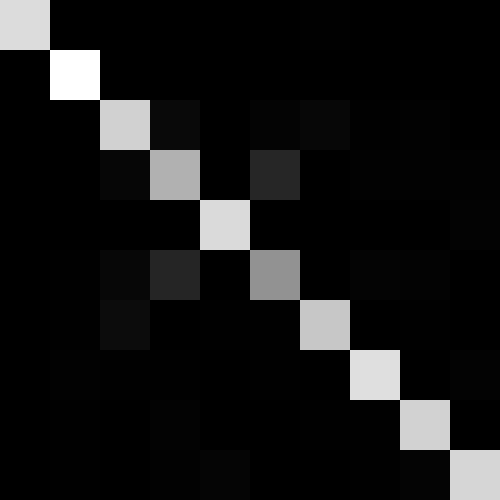

In [58]:
img.resize((500, 500))

In [24]:
testi = MNIST('../../', train=False)

In [37]:
show = []
schoice = []
starget = []
for img, target in testi:
    x = transforms.ToTensor()(img).view(-1, 1, 1).to(device)
    mem, _ = mem_model(x)
    outputs, _ = post_model(mem[-1].expand(56, 1, 256))
    choice = torch.argmax(outputs.mean(dim=0), 1).item()
    if choice != target:
        show.append(img)
        schoice.append(choice)
        starget.append(target)
        if len(show) == 10:
            break


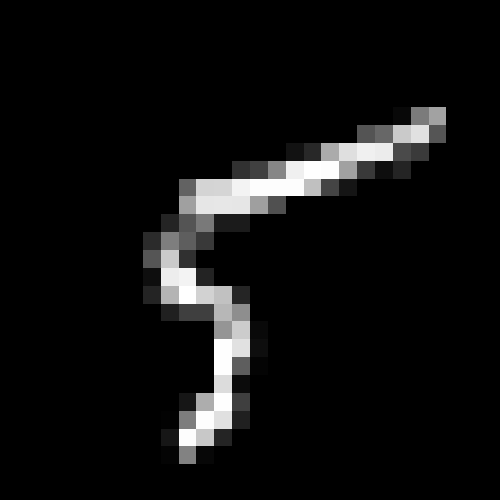

In [51]:
show[7].resize((500,500))


In [39]:
print(schoice)
print(starget)

[2, 3, 8, 5, 6, 6, 5, 7, 7, 5]
[5, 5, 3, 3, 3, 2, 3, 5, 9, 3]


5

In [51]:
mem_model.model.model.layers.shortterm_synapse.named_parameters()

<generator object Module.named_parameters at 0x7f73a476be60>

In [55]:
for name, p in n_mem.named_parameters():
    print(name, p.shape)

model.layers.pre_mem_synapse.weight torch.Size([128, 193])
model.layers.pre_mem_synapse.bias torch.Size([128])
model.layers.pre_mem.initial_mem torch.Size([128])
model.layers.shortterm_synapse.weight torch.Size([64, 128])
model.layers.shortterm_synapse.bias torch.Size([64])
model.layers.shortterm.initial_mem torch.Size([64])
model.layers.output_synapse.weight torch.Size([128, 128])
model.layers.output_synapse.bias torch.Size([128])
model.layers.output.initial_mem torch.Size([128])


In [56]:
for name, p in mem_model2.named_parameters():
    print(name, p.shape)

model.layers.pre_mem_synapse.weight torch.Size([128, 129])
model.layers.pre_mem_synapse.bias torch.Size([128])
model.layers.pre_mem.initial_mem torch.Size([128])
model.layers.output_synapse.weight torch.Size([128, 128])
model.layers.output_synapse.bias torch.Size([128])
model.layers.output.initial_mem torch.Size([128])


In [62]:
mem_model2 = torch.load('../../models/mem_nores3_76')
n_mem = make_SequenceWrapper(DynNetwork(mem_loop), USE_JIT)
with torch.no_grad():
    n_mem.model.layers.output_synapse.weight = mem_model2.model.layers.output_synapse.weight
    n_mem.model.layers.output_synapse.bias = mem_model2.model.layers.output_synapse.bias
    n_mem.model.layers.output.initial_mem = mem_model2.model.layers.output.initial_mem
    n_mem.model.layers.pre_mem_synapse.bias = mem_model2.model.layers.pre_mem_synapse.bias
    n_mem.model.layers.pre_mem.initial_mem = mem_model2.model.layers.pre_mem.initial_mem
    n_mem.model.layers.pre_mem_synapse.weight[:, :129] = mem_model2.model.layers.pre_mem_synapse.weight

In [13]:
data_loader.__iter__().__next__()[1]

tensor([5, 0, 4, 1, 9, 2, 1, 3, 1, 4, 3, 5, 3, 6, 1, 7, 2, 8, 6, 9, 4, 0, 9, 1,
        1, 2, 4, 3, 2, 7, 3, 8, 6, 9, 0, 5, 6, 0, 7, 6, 1, 8, 7, 9, 3, 9, 8, 5,
        9, 3, 3, 0, 7, 4, 9, 8, 0, 9, 4, 1, 4, 4, 6, 0, 4, 5, 6, 1, 0, 0, 1, 7,
        1, 6, 3, 0, 2, 1, 1, 7, 9, 0, 2, 6, 7, 8, 3, 9, 0, 4, 6, 7, 4, 6, 8, 0,
        7, 8, 3, 1, 5, 7, 1, 7, 1, 1, 6, 3, 0, 2, 9, 3, 1, 1, 0, 4, 9, 2, 0, 0,
        2, 0, 2, 7, 1, 8, 6, 4])